In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
import matplotlib as mpl


Using TensorFlow backend.


In [16]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [3]:
data = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0,parse_dates=True, index_col=0)

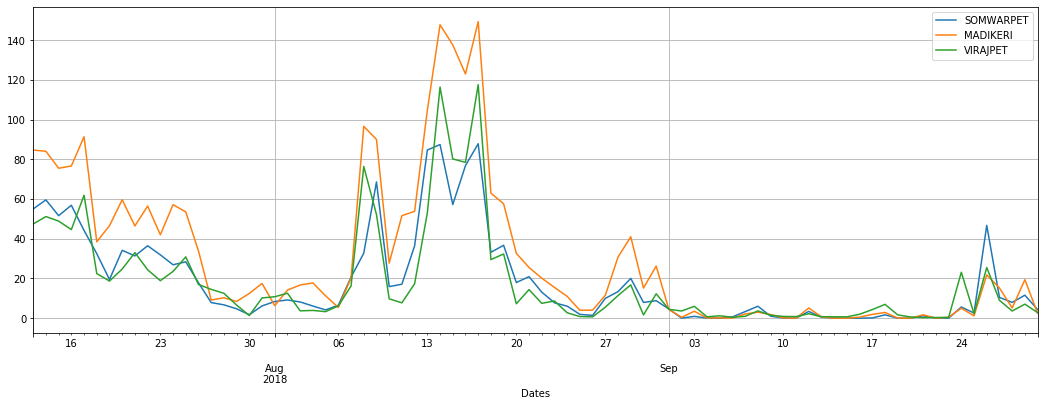

In [21]:
data.iloc[2750:2830].plot(y=['SOMWARPET','MADIKERI','VIRAJPET'])

In [4]:
data=data.drop(columns = ['Present Storage(TMC)', 'Reservoir Level(TMC)', 'Outflow'])
print(data.head(5))

            Inflow  MADIKERI  SOMWARPET  VIRAJPET
Dates                                            
2011-01-01   142.0       0.0        0.0       0.0
2011-01-02   239.0       0.0        0.0       0.0
2011-01-03   166.0       0.0        0.0       0.0
2011-01-04   118.0       0.0        0.0       0.0
2011-01-05   130.0       0.0        0.0       0.0


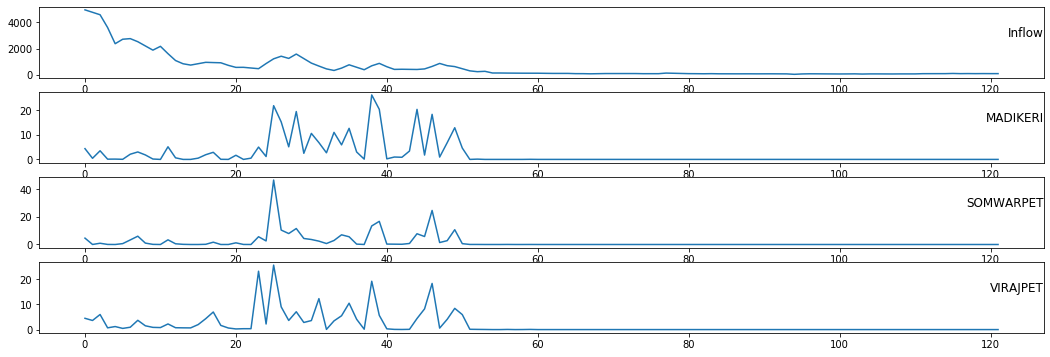

In [10]:
# load dataset
dataset = data#pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[2800:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [97]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 3)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.drop(reframed.columns[[-2,-3,-4,-5,-6,-7,-8,-9]], axis=1, inplace=True)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t+2)
3,0.001823,0.0,0.0,0.0,0.003068,0.0,0.0,0.0,0.002131,0.0,0.0,0.0,0.002144
4,0.003068,0.0,0.0,0.0,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001913
5,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.001682
6,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001438
7,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913,0.0,0.0,0.0,0.002054


In [98]:
values = reframed.values
n_hours = 3
n_features = 4
n_train_days = 365 * 2
train = values[:n_train_days, :]
test = values[n_train_days:, :]
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 12) 730 (730,)
(730, 3, 4) (730,) (2187, 3, 4) (2187,)


In [99]:
len(data.loc['2013-01-06' :'2018-12-29'])

2184

Train on 730 samples, validate on 2187 samples
Epoch 1/70
 - 0s - loss: 0.0129 - val_loss: 0.0143
Epoch 2/70
 - 0s - loss: 0.0091 - val_loss: 0.0137
Epoch 3/70
 - 0s - loss: 0.0076 - val_loss: 0.0131
Epoch 4/70
 - 0s - loss: 0.0069 - val_loss: 0.0130
Epoch 5/70
 - 0s - loss: 0.0066 - val_loss: 0.0123
Epoch 6/70
 - 0s - loss: 0.0068 - val_loss: 0.0121
Epoch 7/70
 - 0s - loss: 0.0074 - val_loss: 0.0116
Epoch 8/70
 - 0s - loss: 0.0068 - val_loss: 0.0113
Epoch 9/70
 - 0s - loss: 0.0069 - val_loss: 0.0111
Epoch 10/70
 - 0s - loss: 0.0066 - val_loss: 0.0107
Epoch 11/70
 - 0s - loss: 0.0068 - val_loss: 0.0107
Epoch 12/70
 - 0s - loss: 0.0068 - val_loss: 0.0110
Epoch 13/70
 - 0s - loss: 0.0068 - val_loss: 0.0110
Epoch 14/70
 - 0s - loss: 0.0060 - val_loss: 0.0105
Epoch 15/70
 - 0s - loss: 0.0060 - val_loss: 0.0108
Epoch 16/70
 - 0s - loss: 0.0061 - val_loss: 0.0108
Epoch 17/70
 - 0s - loss: 0.0060 - val_loss: 0.0107
Epoch 18/70
 - 0s - loss: 0.0059 - val_loss: 0.0106
Epoch 19/70
 - 0s - loss: 

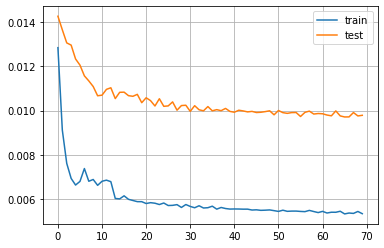

In [100]:
model = Sequential()
model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [101]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhatx = concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhaty = scaler.inverse_transform(inv_yhatx)
inv_yhat = inv_yhaty[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_yx = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_yy = scaler.inverse_transform(inv_yx)
inv_y = inv_yy[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2276.279


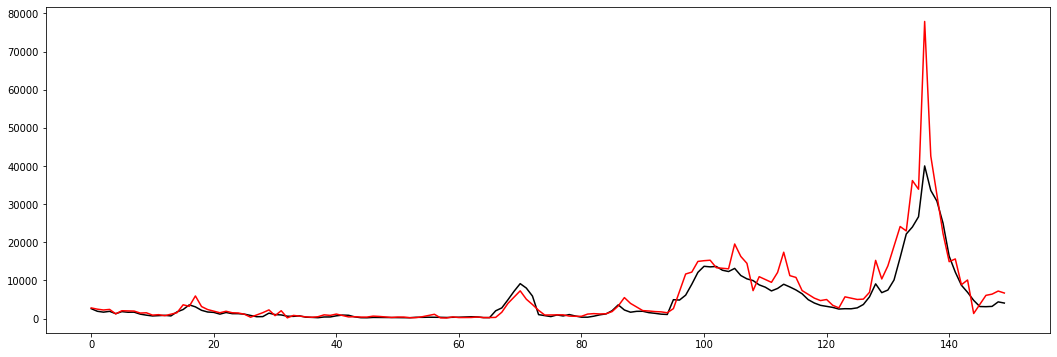

In [65]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = False
pyplot.plot(inv_yhat[703:853],c='black')
pyplot.plot(inv_y[700:850],c='red')
pyplot.show()

In [54]:
outform = pd.DataFrame()
outform['tar']=inv_y
outform['out']=inv_yhat

In [55]:
outform.to_csv('/home/kishora/Documents/testResult/lstmtestLag3_plus3_year3.csv')

In [66]:
sqrt(mean_squared_error(inv_y[:-3], inv_yhat[3:]))

2092.00585563234

In [38]:
df=data

In [39]:
df.loc[df.index.month==8]

,Present Storage(TMC),Reservoir Level(TMC),Inflow,Outflow,MADIKERI,SOMWARPET,VIRAJPET
RCDATE,,,,,,,
2011-08-01,7.57,2856.240,2576.0,5335.0,17.2000,10.166667,9.750000
2011-08-02,7.66,2856.520,3519.0,2400.0,29.0000,12.583333,10.000000
2011-08-03,7.88,2857.160,6208.0,3679.0,60.2500,42.250000,32.916667
2011-08-04,7.82,2856.980,7017.0,7700.0,55.1250,32.666667,28.416667
2011-08-05,7.90,2857.215,7948.5,7750.0,40.2500,31.850000,53.000000
...,...,...,...,...,...,...,...
2018-08-27,7.30,2855.460,6071.0,3800.0,11.5325,9.976667,5.533333
2018-08-28,7.47,2855.960,6391.0,4400.0,30.8000,13.376667,11.406667
2018-08-29,7.61,2856.360,7199.0,5600.0,41.0275,20.045000,16.780000


In [6]:
metrik = {2:{},3:{},4:{},5:{},6:{}}
outval=[]

In [104]:
def doItYourself(n_hours,train_len,h_nodes,itera):
    reframed = series_to_supervised(scaled, n_hours, 3)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
    reframed.drop(reframed.columns[[-2,-3,-4,-5,-6,-7,-8,-9]], axis=1, inplace=True)
    values = reframed.values
#     n_hours = 4
    n_features = 4
    n_train_days = 365 * train_len
    train = values[:n_train_days, :]
    print(train[-1])
    test = values[n_train_days:, :]
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -1]
    test_X, test_y = test[:, :n_obs], test[:, -1]
#     print(train_X.shape, len(train_X), train_y.shape)
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
#     print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    model = Sequential()
    model.add(LSTM(h_nodes, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=itera, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
#     pyplot.plot(history.history['loss'], label='train')
#     pyplot.plot(history.history['val_loss'], label='test')
#     pyplot.legend()
#     pyplot.show()
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhatx = concatenate((yhat, test_X[:, -3:]), axis=1)
    inv_yhaty = scaler.inverse_transform(inv_yhatx)
    inv_yhat = inv_yhaty[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_yx = concatenate((test_y, test_X[:, -3:]), axis=1)
    inv_yy = scaler.inverse_transform(inv_yx)
    inv_y = inv_yy[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    outform = pd.DataFrame()
    outform['tar']=inv_y[:-3]
    outform['out']=inv_yhat[3:]
    index = pd.date_range('2013-01-05', '2018-12-28')
    outform=outform.set_index(index)
#     outform['shift']=outform.out.shift(-3)
    outform.to_csv('/home/kishora/Documents/testResult/bestLstm_lag_3_d2')
    outval.append([rmse, sqrt(mean_squared_error(inv_y[:-3], inv_yhat[3:]))])
    print(sqrt(mean_squared_error(np.array(outform.iloc[:,0]),np.array(outform.iloc[:,1]))))
#     print('Test RMSE: %.3f' % rmse)
    

In [105]:
# for i in range(2,7):
doItYourself(3,2,50,75)

[0.00181001 0.02905171 0.05011122 0.         0.00178211 0.02953591
 0.0509464  0.         0.0017542  0.0300201  0.05178159 0.
 0.00167048]
Train on 730 samples, validate on 2187 samples
Epoch 1/75
 - 0s - loss: 0.0101 - val_loss: 0.0169
Epoch 2/75
 - 0s - loss: 0.0098 - val_loss: 0.0135
Epoch 3/75
 - 0s - loss: 0.0078 - val_loss: 0.0129
Epoch 4/75
 - 0s - loss: 0.0078 - val_loss: 0.0122
Epoch 5/75
 - 0s - loss: 0.0073 - val_loss: 0.0118
Epoch 6/75
 - 0s - loss: 0.0074 - val_loss: 0.0113
Epoch 7/75
 - 0s - loss: 0.0068 - val_loss: 0.0110
Epoch 8/75
 - 0s - loss: 0.0070 - val_loss: 0.0107
Epoch 9/75
 - 0s - loss: 0.0067 - val_loss: 0.0104
Epoch 10/75
 - 0s - loss: 0.0067 - val_loss: 0.0102
Epoch 11/75
 - 0s - loss: 0.0070 - val_loss: 0.0101
Epoch 12/75
 - 0s - loss: 0.0069 - val_loss: 0.0109
Epoch 13/75
 - 0s - loss: 0.0067 - val_loss: 0.0106
Epoch 14/75
 - 0s - loss: 0.0059 - val_loss: 0.0105
Epoch 15/75
 - 0s - loss: 0.0063 - val_loss: 0.0108
Epoch 16/75
 - 0s - loss: 0.0061 - val_loss

In [86]:
#lstm testing
from pprint import pprint
pprint(metrik) #using all year as dataset
# {lag :{#ofyear :[actual RMSE , shifted(-3) RMSE]}}

{2: {},
 3: {},
 4: {},
 5: {},
 6: {1: [2094.3362910478345, 1215.2234876762382],
     2: [2240.733138952517, 1077.3690175608356],
     3: [2321.014110254395, 1326.0662690831102]}}


In [72]:
metrik1=metrik
pprint(metrik1) #using june-to-october dataset

{2: {1: [3292.160233038483, 1732.0497972056114],
     2: [3523.5442384054154, 1788.5566806785855],
     3: [3596.0967728914084, 2186.7932000991773]},
 3: {1: [3237.040469317614, 1718.4083478614739],
     2: [3539.061457505365, 1915.9116628905415],
     3: [3608.866581075006, 2223.5268156691973]},
 4: {1: [3305.122690612256, 1961.1736282134736],
     2: [3551.513198623933, 2003.494010472704],
     3: [3603.0403827878476, 2406.5202056080893]},
 5: {1: [3331.294192952643, 2166.145655305755],
     2: [3558.9922731020365, 2152.6959841092284],
     3: [3576.0781591011123, 2370.088605938605]}}


In [82]:
metrik1=metrik
pprint(metrik1) 

{2: {1: [2144.380679823431, 1072.4628781454396],
     2: [2252.3887319909945, 1054.8467305727406],
     3: [2285.3546770687476, 1207.0948077926605]},
 3: {1: [2114.7949073137092, 1210.0612071296227],
     2: [2261.242136525852, 1043.42614736262],
     3: [2352.4816683664085, 1257.2525601485167]},
 4: {1: [2109.043503581659, 1357.4916666410884],
     2: [2254.4885229248785, 1206.594691683997],
     3: [2351.8119610206936, 1447.0180112908063]},
 5: {1: [2107.852343025953, 1294.3061365071248],
     2: [2275.402052385468, 1172.3842693417546],
     3: [2318.028256945976, 1326.9645341907221]}}


In [87]:
pprint(metrik)

{2: {},
 3: {},
 4: {},
 5: {},
 6: {1: [2094.3362910478345, 1215.2234876762382],
     2: [2240.733138952517, 1077.3690175608356],
     3: [2321.014110254395, 1326.0662690831102]}}


In [23]:
len(outval)

15

In [24]:
X = np.array(outval)

In [25]:
ym=np.arange(1,16)

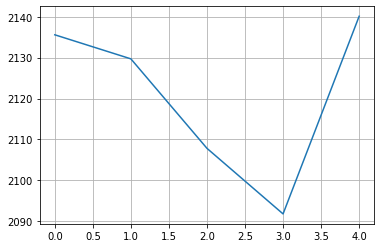

In [12]:
mpl.rcParams['axes.grid'] = True
pyplot.plot(X[:,0])

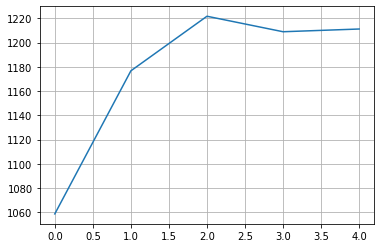

In [13]:
pyplot.plot(X[:,1])

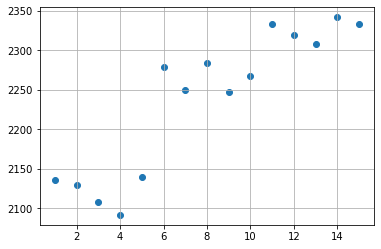

In [26]:
pyplot.scatter(x=ym,y=X[:,0])

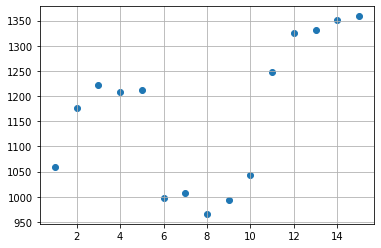

In [27]:
pyplot.scatter(x=ym,y=X[:,1])# shifted RMSE over number of iterations ranging from 40 to 80

In [158]:
ym.shape

(41,)

In [28]:
X

array([[2135.57884425, 1058.63384841],
       [2129.69868761, 1176.74774272],
       [2107.83692443, 1221.80020871],
       [2091.81524041, 1209.01054586],
       [2140.11109525, 1211.26003608],
       [2278.5218893 ,  997.97325866],
       [2249.22486648, 1006.60267112],
       [2283.58730948,  965.86528564],
       [2247.7271854 ,  994.36902104],
       [2267.16552109, 1043.86529303],
       [2333.36420218, 1248.64301343],
       [2318.81974289, 1326.05736113],
       [2307.79927637, 1331.87081768],
       [2341.76535972, 1350.18012687],
       [2333.67339189, 1358.62315415]])

In [43]:
values[:730, :].shape

(730, 4)

In [75]:
scaled[736:740]

array([[0.00132221, 0.        , 0.        , 0.        ],
       [0.00125802, 0.        , 0.        , 0.        ],
       [0.00130937, 0.        , 0.        , 0.        ],
       [0.00127086, 0.        , 0.        , 0.        ]], dtype=float32)

In [77]:
test_y[-10:-1]

array([0.00123235, 0.00124519, 0.00125802, 0.00143774, 0.00125802,
       0.00132221, 0.00125802, 0.00130937, 0.00127086], dtype=float32)

In [79]:
tar[-10:-1]

NameError: name 'tar' is not defined

In [103]:
inv_y[:5]

array([127.95653 , 125.78261 , 123.60869 , 121.434784, 119.26087 ],
      dtype=float32)